Lending-Club Project:
I will explore past loan data and try to build a model that will predict
if a loan will be paid off on time or not.

Import pandas and remove first line as it contains extraneous text

In [119]:
import pandas as pd

loans_2007=pd.read_csv("LoanStats3a.csv", skiprows=1,low_memory=False)
half_count = len(loans_2007)/2
loans_2007= loans_2007.dropna(thresh=half_count,axis=1)

loans_2007 = loans_2007.drop(['desc'],axis=1)


loans_2007.to_csv('loans_2007.csv', index=False)

#print(loans_2007.iloc[0])

Dataframe contains many columns so it is helpfull to explore few at a time. Also, this will allow us to pay attention to any features that leak 
data from the future, causing our model to overfit. 

In [120]:
cols_drop=["funded_amnt", "funded_amnt_inv", "grade",
           "sub_grade", "emp_title", "issue_d"]

loans_2007=loans_2007.drop(cols_drop,axis=1)


In [121]:
cols_drop=["zip_code", "out_prncp", "out_prncp_inv", "total_pymnt",
"total_pymnt_inv", "total_rec_prncp"]
loans_2007= loans_2007.drop(cols_drop,axis=1)


In [122]:
cols_drop=["total_rec_int", "total_rec_late_fee", "recoveries", "collection_recovery_fee",
           "last_pymnt_d", "last_pymnt_amnt"]
loans_2007= loans_2007.drop(cols_drop,axis=1)


In [123]:
print(loans_2007.iloc[0])
print(loans_2007.shape[1])

loan_amnt                            5000
term                            36 months
int_rate                           10.65%
installment                        162.87
emp_length                      10+ years
home_ownership                       RENT
annual_inc                          24000
verification_status              Verified
loan_status                    Fully Paid
pymnt_plan                              n
purpose                       credit_card
title                            Computer
addr_state                             AZ
dti                                 27.65
delinq_2yrs                             0
earliest_cr_line                 Jan-1985
inq_last_6mths                          1
open_acc                                3
pub_rec                                 0
revol_bal                           13648
revol_util                          83.7%
total_acc                               9
initial_list_status                     f
last_credit_pull_d               N

In [124]:
loans_2007= loans_2007.drop(['hardship_flag','disbursement_method','debt_settlement_flag'],axis=1)


In [125]:
print(loans_2007.shape[1])

32


In [126]:
print(loans_2007["loan_status"].value_counts())

Fully Paid                                             34116
Charged Off                                             5670
Does not meet the credit policy. Status:Fully Paid      1988
Does not meet the credit policy. Status:Charged Off      761
Name: loan_status, dtype: int64


For our binary classification problem, we are interested in
Full Paid and Charged Off loan status.

Keep in mind the class imbalance between positive and negative cases

In [127]:
loans_2007 = loans_2007[(loans_2007['loan_status'] == "Fully Paid") | (loans_2007['loan_status'] == "Charged Off")]

In [128]:
print(loans_2007["loan_status"].value_counts())

Fully Paid     34116
Charged Off     5670
Name: loan_status, dtype: int64


Below I use pd.df.replace method to assign binary [0,1] to data

In [129]:
mapping_dict = {
    "loan_status": {
        "Fully Paid": 1,
        "Charged Off": 0,}}

loans_2007 = loans_2007.replace(mapping_dict)

Remove any columns that contain only one unique value since they
won't be useful for the model.

In [130]:
drop_columns=[]
orig_cols= loans_2007.columns

for col in orig_cols:
    unique_col = loans_2007[col].dropna().unique()
    if len(unique_col)==1:
        drop_columns.append(col)
        
loans_2007=loans_2007.drop(drop_columns,axis=1)  


More data engineering.... Next I will handle any missing values and convert categorical columns to numeric ones.

In [131]:
null_counts=loans_2007.isnull().sum()
print(null_counts)

loan_amnt                 0
term                      0
int_rate                  0
installment               0
emp_length                0
home_ownership            0
annual_inc                0
verification_status       0
loan_status               0
purpose                   0
title                    10
addr_state                0
dti                       0
delinq_2yrs               0
earliest_cr_line          0
inq_last_6mths            0
open_acc                  0
pub_rec                   0
revol_bal                 0
revol_util               50
total_acc                 0
last_credit_pull_d        2
pub_rec_bankruptcies    697
dtype: int64


Let's first remove pub_rec_bank columns entirely and then remove rows of 
containing missing values of other two.

In [132]:
loans_2007= loans_2007.drop("pub_rec_bankruptcies",axis=1)
loans_2007 = loans_2007.dropna(axis=0)

While numerical columns can be usewd with scikit-learn, "object" columns
that contain text need to be converted to numerical data types

In [133]:
object_columns_df = loans_2007.select_dtypes(include=["object"])
#print(object_columns_df)

Some of the columns seem like they represent categorical values, but we should confirm by checking the number of unique values in those columns

In [134]:
cols = ['home_ownership', 'verification_status', 'emp_length', 'term', 'addr_state']

for c in cols:
    print(loans_2007[c].value_counts())
    

RENT        18881
MORTGAGE    17688
OWN          3056
OTHER          96
NONE            3
Name: home_ownership, dtype: int64
Not Verified       16890
Verified           12833
Source Verified    10001
Name: verification_status, dtype: int64
10+ years    8897
< 1 year     4576
2 years      4389
3 years      4094
4 years      3435
5 years      3279
1 year       3240
6 years      2227
7 years      1771
8 years      1483
9 years      1259
n/a          1074
Name: emp_length, dtype: int64
 36 months    29041
 60 months    10683
Name: term, dtype: int64
CA    7095
NY    3815
FL    2869
TX    2729
NJ    1850
IL    1524
PA    1515
VA    1407
GA    1399
MA    1343
OH    1221
MD    1053
AZ     878
WA     841
CO     791
NC     788
CT     754
MI     722
MO     685
MN     613
NV     497
SC     472
WI     459
AL     451
OR     450
LA     436
KY     327
OK     299
KS     271
UT     259
AR     245
DC     212
RI     199
NM     190
WV     177
HI     173
NH     172
DE     113
MT      85
WY      83
AK      

The home_ownership, verification_status, emp_length, term, and addr_state columns all contain multiple discrete values. We should clean the emp_length column and treat it as a numerical one since the values have ordering (2 years of employment is less than 8 years).

In [135]:
# value_counts displayes unique value in columns selected

col=["purpose","title"]

for c in col:
    print(loans_2007[c].value_counts()) 

debt_consolidation    18661
credit_card            5134
other                  3985
home_improvement       2980
major_purchase         2182
small_business         1827
car                    1549
wedding                 947
medical                 693
moving                  581
house                   382
vacation                380
educational             320
renewable_energy        103
Name: purpose, dtype: int64
Debt Consolidation                           2189
Debt Consolidation Loan                      1732
Personal Loan                                 661
Consolidation                                 516
debt consolidation                            508
Credit Card Consolidation                     357
Home Improvement                              357
Debt consolidation                            334
Small Business Loan                           329
Credit Card Loan                              319
Personal                                      309
Consolidation Loan            

In [136]:
cols=["last_credit_pull_d", "earliest_cr_line", "addr_state", "title"]

loans_2007 = loans_2007.drop(cols,axis=1)

loans_2007["int_rate"]=loans_2007['int_rate'].str.rstrip('%').astype("float")

loans_2007["revol_util"]=loans_2007["revol_util"].str.rstrip('%').astype("float")


In [137]:
mapping_dict = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0
    }
}

loans_2007= loans_2007.replace(mapping_dict)


Above we used python's helpful method to clean up "emp_length" columns. Now let's encode "home_ownership", "verification_status", "title", and "term" columns as dummy variables so we can use them later in the model.


In [138]:
dum_columns = ["home_ownership", "verification_status","purpose", "term"]

dummy_df= pd.get_dummies(loans_2007[dum_columns])

#use concat method to add these dummy columns back to loans_2007 df
loans_2007= pd.concat([loans_2007,dummy_df],axis=1)

# then drop original columns entirely 
loans_2007 = loans_2007.drop(dum_columns,axis=1)


Before diving into predicting loan_status, it is important to keep in mind our original goal:
can we build ML model that can accurately predict if a borrower will pay off their loan or not.
An error metric should be established to help us figure out when the model does well. Lending Club's objective is obviously to make money, they want to fund enough loans that are paid off on time to offset losses from loans that aren't paid off. 
The error metric we should be concerned with are false positives and false negatives.
With a false positive, model predicts that a loan will be paid off on time, but it actually isn't.(dangerous)
With a false negative, we predict that a loan won't be paid off on time, but it actually would be paid off on time.(less dangerous)

Note: keep an deye on imbalance in data, skewed towards 1's. 


In [139]:
loans_2007['loan_status'].value_counts()/loans_2007.shape[0]


1    0.857743
0    0.142257
Name: loan_status, dtype: float64

Let's write a help fuction to calculate below metrics.

As mentioned above, class imbalance in loan_status columns in prevalent,6 times as many 1's as 0's. This causes a major issue when we use accuracy as a metric. This is because due to the class imbalance, a classifier can predict 1 for every row, and still have high accuracy. 
For exaple, if we made 7 loans, and predicted class 1 for all, we should still be 85.7% accurate in our prediction,(identified that many cases correctly), and although this might be a high accuracy, it is not the case for this problme. If 7 loans, 1000 each paid us 10% interest,with 1 default we would receive 600 dollars i/r profit and incur 1000 loss on the lost principle, total losses -400 dollars.
This is why it's important to always be aware of imbalanced classes in machine learning models, and to adjust your error metric accordingly.

False positive rate(fpr) =  fp / (fp + tn)
: "what percentage of my 1 predictions are incorrect?" or "what percentage of the loans that I fund would not be repaid?"


True Positive Rate (tpr) = tp / (tp + fn)
: "what percentage of all the possible 1 predictions am I making?" or "what percentage of loans that could be funded would I fund?"



In [140]:
def compute_metrics(predictions):
    predictions = pd.Series(predictions)
    
    tn_filter=(predictions==0)&(loans_2007["loan_status"]==0)
    tn = len(predictions[tn_filter])
    
    tp_filter= (predictions==1)& (loans_2007["loan_status"]==1)
    tp= len(predictions[tp_filter])
    
    fn_filter= (predictions==0) & (loans_2007["loan_status"]==1)
    fn = len(predictions[fn_filter])
    
    fp_filter= (predictions==1) & (loans_2007["loan_status"]==0)
    fp= len(predictions[fp_filter])
    
    fpr = fp /(fp+tn)
    tpr = tp / (tp+fn)
    
    print(tpr* 100)
    print(fpr*100)


In [141]:
#loans_2007.info()

#https://machinelearningmastery.com/assessing-comparing-classifier-performance-roc-curves-2/

In [142]:
cols = loans_2007.columns

train_col = cols.drop("loan_status")

#Our X's
features=loans_2007[train_col]

#Our Y
target= loans_2007["loan_status"]

Let's start with simple Logistic Regression 

In [144]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

lr.fit(features,target)

predictions=lr.predict(features)

In [145]:
#Let's compute performance
metrics =compute_metrics(predictions)
print(metrics)

99.91768821471616
99.92914083259522
None


Above predictions were overfit because we generated predictions from the same data we trained our predictions on, hence unrealistically high depiction of how accurate algorithm is.
In order to get realistic depiction, we'll use cross-validation to generate more accurate predictions. Cross validation splits the dataset into groups, then makes predictions on each group using the other groups as training data. This ensures that we don't overfit by generating predictions on the same data that we train our algorithm with. 

In [146]:
from sklearn.cross_validation import cross_val_predict, KFold
lr = LogisticRegression()

kf = KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr, features, target, cv=kf)
predictions = pd.Series(predictions)


In [147]:
metrics =compute_metrics(predictions)
print(metrics)

99.91180880148161
99.94685562444641
None


Unfortunately,classifier isn't accounting for the imbalance in the classes(0,1). 
Solution: Tell the classifier to penalize misclassifications of the less prevalent class(0) more than the other(1) class.

We can do this by setting the class_weight parameter to "balanced" when creating the LogisticRegression instance. This tells scikit-learn to penalize the misclassification of the minority class during the training process. The penalty means that the logistic regression classifier pays more attention to correctly classifying rows where loan_status is 0. This lowers accuracy when loan_status is 1, but raises accuracy when loan_status is 0.
This would mean that for the classifier, correctly classifying a row where loan_status is 0 is 6 times more important than correctly classifying a row where loan_status is 1.

Let's repeat KFold with strategy presented above.

In [148]:
lr= LogisticRegression(class_weight="balanced")

kf= KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr,features,target, cv=kf)

predictions = pd.Series(predictions)

In [91]:
metrics =compute_metrics(predictions)
print(metrics)

62.374695005438454
58.56510186005315
None


Significantly improved: False positive is around 58% while True positive is 62%. From a conservative investor's standpoint, it's reassuring that the false positive rate is lower because it means that we'll be able to do a better job at avoiding bad loans than if we funded everything. However, only 62% of good loans are being funded... In the last screen, the penalty scikit-learn imposed for misclassifying a 0 would have been around 5.89 (since there are 5.89 times as many 1s as 0s). Let's try to set penalty manually in the next try.

In [149]:
#pass in a dictionary of penalty values to the class_weight parameter
# play around with 0:penalty

penalty = { 0: 10, 1: 1 }

lr= LogisticRegression(class_weight=penalty)

kf= KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(lr,features,target, cv=kf)

predictions = pd.Series(predictions)

metrics =compute_metrics(predictions) 
print(metrics)


20.386865390833993
19.41541186891054
None


It looks like false positive rate was lowered to 19% and it comes at the expense of the true positive rate. While we have fewer false positives, we're also missing opportunities to fund more loans and potentially make more money. 
Next, let's try random forests: unlike logistic regression that only works with linear data, RF are able to fit nonlinear data.

Let's determine best parameter with GridSearch


In [152]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.cross_validation import cross_val_predict

rf= RandomForestClassifier(class_weight="balanced",random_state=1)

kf= KFold(features.shape[0], random_state=1)

predictions = cross_val_predict(rf,features,target, cv=kf)

predictions = pd.Series(predictions)

metrics =compute_metrics(predictions) 
print(metrics)
                        

97.13966546138695
96.59875996457042
None


Unfortunately, using a random forest classifier didn't improve our false positive rate. The model is likely weighting too heavily on the 1 class, and still mostly predicting 1s.

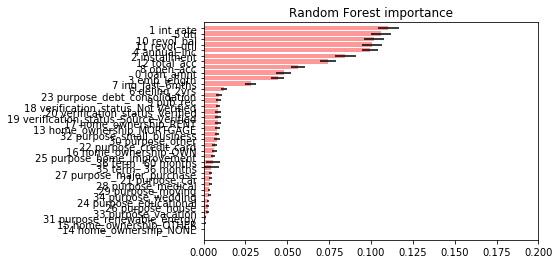

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor

RF = RandomForestRegressor(n_estimators=100, random_state=1).fit(features,target)



feature_names = np.array([' '.join([str(b), a]) for a,b in
zip(features.columns,range(len(features.columns)))])


importance = np.mean([tree.feature_importances_ for tree in RF.estimators_],axis=0)
std = np.std([tree.feature_importances_ for tree in RF.estimators_],axis=0)
indices = np.argsort(importance)
range_ = range(len(importance))
plt.figure()
plt.title("Random Forest importance")

plt.barh(range_,importance[indices], color="r", xerr=std[indices], alpha=0.4, align="center")

plt.yticks(range(len(importance)), feature_names[indices])
plt.ylim([-2, len(importance)])
plt.xlim([0.0, 0.20])
plt.show()